### Importing all the necessary Libraries

In [ ]:
!pip install scikit-optimize
!pip install pandas==1.4.4
!pip install scikit-optimize

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import scipy.sparse
import gensim.models
from scipy.sparse import hstack
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor,Lasso,Ridge,ElasticNet
import joblib
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from skopt import BayesSearchCV
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,Dropout,Flatten,concatenate
import tensorflow.keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import mean_squared_logarithmic_error
import warnings
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torchvision.transforms import ToTensor
%matplotlib inline
warnings.filterwarnings("ignore")
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from prettytable import PrettyTable
import joblib
import gc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
import datetime
%load_ext tensorboard

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Loading the train dataframe from joblib

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
df_train = joblib.load('/content/gdrive/MyDrive/binary_files/df_train_26Jan23_v1.joblib')
df_cval = joblib.load('/content/gdrive/MyDrive/binary_files/df_cval_26Jan23_v1.joblib')
df_test = joblib.load('/content/gdrive/MyDrive/binary_files/df_test_26Jan23_v1.joblib')

In [ ]:
y_train = np.array(df_train['price'].values).reshape(-1, 1)
y_cval    = np.array(df_cval['price'].values).reshape(-1, 1)

In [ ]:
y_train = np.log1p(y_train)

In [ ]:
trainframe = joblib.load( '/content/gdrive/MyDrive/binary_files/trainframe_26Jan23_v1.joblib')
cvalframe = joblib.load('/content/gdrive/MyDrive/binary_files/cvalframe_26Jan23_v1.joblib')
testframe = joblib.load('/content/gdrive/MyDrive/binary_files/testframe_26Jan23_v1.joblib')

In [ ]:
target = df_train['log_price'].values
cvaltar = df_cval['log_price'].values

In [ ]:
# Original price
targ1=np.expm1(target)
cvaltar1=np.expm1(cvaltar)

### Creating the custom Root Mean squared log error loss function

In [ ]:
def loss(y_true,y_pred):
    """
    Description -> Accepts input y1 and y2 as the true and predicted values respectively to determine the error
                   loss and return it as the output
    """
    return np.sqrt(mean_squared_log_error(y_true,y_pred))

# def rmsle(y_true, y_pred):
#     return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
def losstf(y1,y2):
    """
    Description -> Accepts input y1 and y2 as the true and predicted values respectively to determine the error
                   loss and return it as the output
    """
    return tf.math.sqrt(mean_squared_logarithmic_error(y1,y2))

In [ ]:
def losslgb(y1,y2):
    return 'RMSLE',loss(y1,y2),False

### 1 - L1 Regularization - Lasso Model

In [ ]:
def lasso(X_train,y_train,alpha):
    """
    Description -> Inputs the train dataframe, the target to predict and the alpha parameter to create a linear
                   regression model with L1 Regularization and returns this model.
    """
    model = Lasso(alpha=alpha,max_iter=2000)
    model.fit(X_train,y_train)
    return model

#### Fitting the lasso model

In [ ]:
%%time
clf = lasso(trainframe,target,1)
y_pred = clf.predict(cvalframe)
preds_lasso = np.expm1(y_pred.reshape(-1, 1))
loss(cvaltar1,preds_lasso)

CPU times: user 7min 3s, sys: 414 ms, total: 7min 3s
Wall time: 7min 2s


0.7457773932554702

#### Hyperparameter tuning using gridsearchcv

In [ ]:
param_grid = {
    "alpha": [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [1000,2000]}
gr = GridSearchCV(Lasso(),param_grid,cv=2,n_jobs=-1)

In [ ]:
gridlasso = gr.fit(trainframe,target)

In [ ]:
gridlasso.best_score_

0.5126767667553153


#### Fitting it with the best alpha value found using hyperparameter tuning

In [ ]:
print(gridlasso.best_params_)
best_est = gridlasso.best_estimator_
y_pred_train = best_est.predict(trainframe)
y_pred_cv = best_est.predict(cvalframe)
print("RMSLE loss for train = ", loss(targ1,np.expm1(y_pred_train)))
print("RMSLE loss for CV = ", loss(cvaltar1,np.expm1(y_pred_cv)))

OrderedDict([('alpha', 1), ('max_iter', 2000)])
RMSLE loss for train =  0.7459394918743606
RMSLE loss for CV = 0.7457273932554702


#### Hyperparameter tuning using Bayesian Search

In [ ]:
# ref - https://towardsdatascience.com/bayesian-optimization-for-hyperparameter-tuning-how-and-why-655b0ee0b399
param_grid = {
    "alpha": [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [1000,2000]}
bayes = BayesSearchCV(estimator=SGDRegressor(penalty='l1'),search_spaces=param_grid,n_iter=70,cv=2,n_jobs=-1,random_state=23)

In [ ]:
bayeslasso = bayes.fit(trainframe,target)

In [ ]:
bayeslasso.best_score_

0.5226757616551163

#### Fitting it with the best alpha value found using hyperparameter tuning

In [ ]:
print(bayeslasso.best_params_)
best_est = bayeslasso.best_estimator_
y_pred_train = bayeslasso.predict(trainframe)
y_pred_cv = bayeslasso.predict(cvalframe)
print("RMSLE loss for train = ", loss(targ1,np.expm1(y_pred_train)))
print("RMSLE loss for CV = ", loss(cvaltar1,np.expm1(y_pred_cv)))

OrderedDict([('alpha', 1), ('max_iter', 2000)])
RMSLE loss for train =  0.7459394918743606
RMSLE loss for CV = 0.7457273932554702


### 2 - L2 Regularization - Ridge Model

In [ ]:
def ridge(X_train,y_train,alpha):
    """
    Description -> Inputs the train dataframe, the target to predict and the alpha parameter to create a linear
                   regression model with L2 Regularization and returns this model.
    """
    model = Ridge(alpha=alpha)
    model.fit(X_train,y_train)
    return model

In [ ]:
%%time
clf = ridge(trainframe, target,1)
y_pred = clf.predict(cvalframe)
preds_lasso = np.expm1(y_pred.reshape(-1, 1))[:, 0]
loss(cvaltar1,preds_lasso)

CPU times: user 2min 41s, sys: 3min 33s, total: 6min 15s
Wall time: 2min 13s


0.44464924022481916

#### Hyperparameter tuning using gridsearchcv

In [ ]:
param_grid = {
    "alpha": [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [1000,2000]}
gr1 = RandomizedSearchCV(Ridge(),param_grid,cv=2,n_jobs=-1,random_state=21)

In [ ]:
gridridge = gr1.fit(trainframe,target)

In [ ]:
gridridge.best_score_

0.6293308047288371

#### Fitting it with the best alpha value found using hyperparameter tuning

In [ ]:
print(gridridge.best_params_)
best_est = gridridge.best_estimator_
y_pred_train = best_est.predict(trainframe)
y_pred_cv = best_est.predict(cvalframe)
print("RMSLE loss for train = ", loss(targ1,np.expm1(y_pred_train)))
print("RMSLE loss for CV = ", loss(cvaltar1,np.expm1(y_pred_cv)))

{'max_iter': 2000, 'alpha': 1}
RMSLE loss for train =  0.3980171915030034
RMSLE loss for CV =  0.44464924022481916


#### Hyperparameter tuning using Bayesian Search

In [ ]:
param_grid = {
    "alpha": [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [1000,2000]}
bayes1 = BayesSearchCV(estimator=SGDRegressor(penalty='l1'),search_spaces=param_grid,n_iter=70,cv=2,n_jobs=-1,random_state=23)

In [ ]:
bayesridge = bayes1.fit(trainframe,target)

In [ ]:
bayesridge.best_score_

0.5226782596845778

#### Fitting it with the best alpha value found using hyperparameter tuning

In [ ]:
print(bayesridge.best_params_)
best_est = bayesridge.best_estimator_
y_pred_train = bayesridge.predict(trainframe)
y_pred_cv = bayesridge.predict(cvalframe)
print("RMSLE loss for train = ", loss(targ1,np.expm1(y_pred_train)))
print("RMSLE loss for CV = ", loss(cvaltar1,np.expm1(y_pred_cv)))

{'max_iter': 2000, 'alpha': 1}
RMSLE loss for train =  0.3980171915030034
RMSLE loss for CV =  0.44464924022481916


### 3 - L1 & L2 Regularized - ElasticNet Model

In [ ]:
def elasticnet(X_train,y_train,alpha):
    """
    Description -> Inputs the train dataframe, the target to predict and the alpha parameter to create a linear
                   regression model with L1 & L2 Regularization and returns this model.
    """
    model = ElasticNet(alpha=alpha)
    model.fit(X_train,y_train)
    return model

In [ ]:
%%time
clf = elasticnet(trainframe, target,1)
y_pred = clf.predict(cvalframe)
preds_lasso = np.expm1(y_pred.reshape(-1, 1))[:, 0]
loss(cvaltar1,preds_lasso)

CPU times: user 7min 5s, sys: 360 ms, total: 7min 5s
Wall time: 7min 4s


0.7457773932554702

#### Hyperparameter tuning using gridsearchcv

In [ ]:
param_grid = {
    "alpha": [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [1000,2000]}
gre = RandomizedSearchCV(ElasticNet(),param_grid,cv=2,n_jobs=-1,random_state=21)

In [ ]:
grelas = gre.fit(trainframe,target)

In [ ]:
grelas.best_score_

0.5226728602061765

#### Fitting it with the best alpha value found using hyperparameter tuning

In [ ]:
print(grelas.best_params_)
best_est = grelas.best_estimator_
y_pred_train = clf.predict(trainframe)
y_pred_cv = clf.predict(cvalframe)
print("RMSLE loss for train = ", loss(targ1,np.expm1(y_pred_train)))
print("RMSLE loss for CV = ", loss(cvaltar1,np.expm1(y_pred_cv)))

{'alpha': 1, 'max_iter': 2000}
RMSLE loss for train =  0.7459394918743606
RMSLE loss for CV =  0.7457773932554702


#### Hyperparameter tuning using Bayesian Search

In [ ]:
param_grid = {
    "alpha": [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [1000,2000]}
bayes1 = BayesSearchCV(estimator=SGDRegressor(penalty='elasticnet'),search_spaces=param_grid,n_iter=70,cv=2,n_jobs=-1,random_state=23)

In [ ]:
baelas = bayes1.fit(trainframe,target)

In [ ]:
baelas.best_score_

0.5226915920170052

#### Fitting it with the best alpha value found using hyperparameter tuning

In [ ]:
print(baelas.best_params_)
best_est = grelas.best_estimator_
y_pred_train = best_est.predict(trainframe)
y_pred_cv = best_est.predict(cvalframe)
print("RMSLE loss for train = ", loss(targ1,np.expm1(y_pred_train)))
print("RMSLE loss for CV = ", loss(cvaltar1,np.expm1(y_pred_cv)))

{'alpha': 1, 'max_iter': 2000}
RMSLE loss for train =  0.7459394918743606
RMSLE loss for CV =  0.7457773932554702


### 4 - Support Vector Regression Model

In [ ]:
def svr(X_train,y_train,gamma,max_iter):
    """
    Description -> Inputs the train dataframe, the target to predict, the gamma parameter deciding the spread 
                   and the maximum iterations to create a SVR model which is built based on the concept of SVM 
                   and returns this model. It uses a general purpose radial basis function kernel.
    """
    model = SVR(kernel='rbf',gamma=gamma,max_iter=max_iter)
    model.fit(X_train,y_train)
    return model    

In [ ]:
%%time
clf = svr(trainframe, target,0.1,1000)
y_pred = clf.predict(cvalframe)
preds_lasso = np.expm1(y_pred.reshape(-1, 1))[:, 0]
loss(cvaltar1,preds_lasso)

CPU times: user 16min 53s, sys: 989 ms, total: 16min 54s
Wall time: 16min 51s


0.7724058533734584

#### Hyperparameter tuning using gridsearchcv(not bayesian as it will take too much time)

In [ ]:
param_grid = {
    "gamma": [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
    "max_iter": [1000,2000]}
gr3 = GridSearchCV(SVR(kernel='rbf'),param_grid,cv=2,n_jobs=-1)

In [ ]:
gridsvr = gr3.fit(trainframe,target)

In [ ]:
gridsvr.best_score_

0.18607246108036468

In [ ]:
best_est=SVR(kernel='rbf',gamma=0.1,max_iter=2000)
best_est.fit(trainframe, target)

SVR(gamma=0.1, max_iter=2000)

#### Fitting it with the best alpha value found using hyperparameter tuning

In [ ]:
#print(gridsvr.best_params_)
print("{'gamma': 0.1, 'max_iter': 2000}")
#best_est = gridsvr.best_estimator_
y_pred_train = best_est.predict(trainframe)
y_pred_cv = best_est.predict(cvalframe)
print("RMSLE loss for train = ", loss(targ1,np.expm1(y_pred_train)))
print("RMSLE loss for CV = ", loss(cvaltar1,np.expm1(y_pred_cv)))

{'gamma': 0.1, 'max_iter': 2000}
RMSLE loss for train =  0.6856219523200736
RMSLE loss for CV =  0.6872395181421347


### 5 - XGBoost Model

In [ ]:
def xgb(X_train,y_train,trees,lr):
    """
    Description -> Inputs the train dataframe, the target to predict, the number of trees deciding the spread 
                   and the learning rate to create a XGBoost model which is built based on the concept of boosting 
                   and returns this model. It uses multithreading to decrease the wall time.
    """
    model = XGBRegressor(n_estimators=trees,random_state=23,n_jobs=-1,learning_rate=lr)
    model.fit(X_train,y_train)
    return model

#### Hyperparameter tuning using gridsearchcv

In [ ]:
params = {'n_estimators' : [1125, 1625],
          'max_depth' : [4, 7],
          'subsample' : [0.5, 0.9],
          'colsample_bytree' : [0.5, 0.7],
          'learning_rate': [0.0005, 0.005, 0.05, 0.5]}
clf = GridSearchCV(XGBRegressor(n_jobs=-1),params,cv=2,n_jobs=-1)

In [ ]:
clf.fit(trainframe, target)

[22:14:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GridSearchCV(cv=2, estimator=XGBRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.9],
                         'learning_rate': [0.0005, 0.005, 0.05, 0.5], 'max_depth': [4, 7],
                         'n_estimators': [1125, 1625], 'subsample': [0.9]})



In [ ]:
clf.best_score_

0.5668727863882469


#### Fitting it with the best alpha value found using hyperparameter tuning

In [ ]:
best_est=XGBRegressor(random_state=23,n_jobs=-1,colsample_bytree=0.7,learning_rate=0.5,max_depth=7,subsample=0.9,n_estimators=1625)
best_est.fit(trainframe, target)

[09:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.7, learning_rate=0.5, max_depth=7,
             n_estimators=1625, n_jobs=-1, random_state=23, subsample=0.9)

In [ ]:
#print(clf.best_params_)
print("{'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 1625, 'subsample': 0.9}")
#best_est = clf.best_estimator_
y_pred_train = best_est.predict(trainframe)
y_pred_cv = best_est.predict(cvalframe)
print("RMSLE loss for train = ", loss(targ1,np.expm1(y_pred_train)))
print("RMSLE loss for CV = ", loss(cvaltar1,np.expm1(y_pred_cv)))

{'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 1625, 'subsample': 0.9}
RMSLE loss for train =  0.36187806108410586
RMSLE loss for CV =  0.4500376204091811



### 6 - LightGBM Model

In [ ]:
def lgbm(X_train,y_train,trees,lr,X_cval,y_cval,losslgb):
    """
    Description -> Inputs the train dataframe, the target to predict, the number of trees deciding the spread 
                   and the learning rate to create a XGBoost model which is built based on the concept of boosting 
                   and returns this model. It uses multithreading to decrease the wall time.
    """
    model = LGBMRegressor(n_estimators=trees,random_state=23,n_jobs=-1,learning_rate=lr)
    model.fit(X_train,y_train,eval_set=[(X_cval,y_cval)],early_stopping_rounds=250,verbose=True,eval_metric=losslgb)
    return model

In [ ]:
%%time
model=lgbm(trainframe,target,2000,0.05,cvalframe,cvaltar,losslgb)

[1]	valid_0's l2: 0.543521	valid_0's RMSLE: 0.182846
Training until validation scores don't improve for 250 rounds.
[2]	valid_0's l2: 0.532042	valid_0's RMSLE: 0.180874
[3]	valid_0's l2: 0.521494	valid_0's RMSLE: 0.17904
[4]	valid_0's l2: 0.511976	valid_0's RMSLE: 0.177375
[5]	valid_0's l2: 0.503372	valid_0's RMSLE: 0.175853
[6]	valid_0's l2: 0.495473	valid_0's RMSLE: 0.174446
[7]	valid_0's l2: 0.488056	valid_0's RMSLE: 0.173114
[8]	valid_0's l2: 0.481248	valid_0's RMSLE: 0.171868
[9]	valid_0's l2: 0.475158	valid_0's RMSLE: 0.170754
[10]	valid_0's l2: 0.469279	valid_0's RMSLE: 0.169681
[11]	valid_0's l2: 0.463904	valid_0's RMSLE: 0.168695
[12]	valid_0's l2: 0.458674	valid_0's RMSLE: 0.167725
[13]	valid_0's l2: 0.453921	valid_0's RMSLE: 0.166816
[14]	valid_0's l2: 0.449284	valid_0's RMSLE: 0.165929
[15]	valid_0's l2: 0.44493	valid_0's RMSLE: 0.165115
[16]	valid_0's l2: 0.441088	valid_0's RMSLE: 0.164379
[17]	valid_0's l2: 0.437238	valid_0's RMSLE: 0.163645
[18]	valid_0's l2: 0.43352	val

In [ ]:
print('RMSLE loss for train = ',loss(np.expm1(target),np.expm1(model.predict(trainframe))))
print('RMSLE loss for CV = ',loss(np.expm1(cvaltar),np.expm1(model.predict(cvalframe))))

RMSLE loss for train =  0.4433445243118526
RMSLE loss for CV =  0.4539420079103418


#### Hyperparameter tuning using gridsearchcv

In [ ]:
params = {'n_estimators' : [1625, 2000],
          'max_depth' : [7, 9],
          'subsample' : [0.5, 0.9],
          'colsample_bytree' : [0.5, 0.7],
          'learning_rate': [0.005, 0.05, 0.5]}
grlgb = GridSearchCV(LGBMRegressor(random_state=23,n_jobs=-1),params,cv=2,n_jobs=-1)

In [ ]:
grlgb.fit(trainframe, target)

GridSearchCV(cv=2, estimator=LGBMRegressor(random_state=23), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.005, 0.05, 0.5], 'max_depth': [7, 9],
                         'n_estimators': [1625, 2000], 'subsample': [0.5, 0.9]})


In [ ]:
grlgb.best_score_

0.5840724981362898

#### Fitting it with the best alpha value found using hyperparameter tuning

In [ ]:
print(grlgb.best_params_)
best_est = grlgb.best_estimator_
y_pred_train_lgb = best_est.predict(trainframe)
y_pred_cv_lgb = best_est.predict(cvalframe)
print("RMSLE loss for train = ", loss(targ1,np.expm1(y_pred_train_lgb)))
print("RMSLE loss for CV = ", loss(cvaltar1,np.expm1(y_pred_cv_lgb)))

{'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 9, 'n_estimators': 2000, 'subsample': 0.9}
RMSLE loss for train =  0.3738726594625917
RMSLE loss for CV =  0.4393984143197857


### 7 - MLP Model

In [ ]:
def SMLP(frame,i):    
  input = Input(shape=(frame.shape[1],),sparse=True,dtype='float32')
  output = Dense(i,activation='relu')(input)
  output = BatchNormalization()(output)
  if i==256:                      
    while i!=64:          
      i/=2           
      output = Dense(i,activation='relu')(output)                
  else:                      
    while i!=16:          
      i/=2
      output = Dense(i,activation='relu')(output)  
  output = Dropout(0.2)(output)
  output = Dense(1)(output)
  model = Model(input,output)
  return model

In [ ]:
model1=SMLP(trainframe,256)
model1.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error'])
log_dir = "/content/gdrive/MyDrive/cslogs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

for i in [256,512,1024]:
    model1.fit(trainframe,target, batch_size = i, epochs = 1, verbose = 1,callbacks=[tensorboard_callback])




In [ ]:
tensorboard --logdir /content/gdrive/MyDrive/cslogs/20230126-183335

In [ ]:
y_pred_train = model1.predict(trainframe)[:, 0]
y_pred_train_model1 = np.expm1(y_pred_train.reshape(-1, 1))[:, 0]
print("Model1 -- Train RMSLE : ", loss(targ1, y_pred_train_model1))

In [ ]:
y_pred_cval = model1.predict(cvalframe)[:, 0]
y_pred_cval_model1 = np.expm1(y_pred_cval.reshape(-1, 1))[:, 0]
print("Model1 -- CVAL RMSLE : ", loss(cvaltar1, y_pred_cval_model1))

In [ ]:
model2=SMLP(trainframe,1024)
#google colab session was getting crashed if tensor board is included for model 2
# log_dir1 = "/content/gdrive/MyDrive/cslogs2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=log_dir1, histogram_freq=1)
model2.compile(optimizer='adam',loss='mean_squared_error')
for i in [256,512,1024]:
    #model2.fit(trainframe,target, batch_size = i, epochs = 1, verbose = 1,callbacks=[tensorboard_callback1])
    model2.fit(trainframe,target, batch_size = i, epochs = 1, verbose = 1)

In [ ]:
#tensorboard --logdir1 /content/gdrive/MyDrive/cslogs2/20230126-193409

In [ ]:
y_pred_train = model2.predict(trainframe)[:, 0]
y_pred_train_model2 = np.expm1((y_pred_train.reshape(-1, 1))[:, 0])
print("Model2 -- Train RMSLE : ", loss(targ1, y_pred_train_model2))

In [ ]:
y_pred_cval = model2.predict(cvalframe)[:, 0]
y_pred_cval_model2 = np.expm1(y_pred_cval.reshape(-1, 1))[:, 0]
print("Model2 -- CVAL RMSLE : ", loss(cvaltar1, y_pred_cval_model2))

### Ensembling Models

In [ ]:
def ensemble_generator(model1,model2):
    """
    Description -> It takes 2 models as inputs and finds the best suitable weight that needs to be given to both 
                   models using rmsle loss as a metric to determine it. 
    """    
    sample = np.arange(0,1,0.001)
    losslist = [loss(cvaltar1,(w*model1+(1-w)*model2)) for w in sample]
    wmin = sample[np.argmin(losslist)]
    fpred = (wmin*model1)+((1-wmin)*model2)
    return wmin,fpred

In [ ]:
wmin, final_cv_prediction = ensemble_generator(y_pred_cval_model1,y_pred_cval_model2)
final_train_prediction = wmin*y_pred_train_model1 + (1-wmin)*y_pred_train_model2
print("Optimum Weight = ", wmin)
print("RMSLE loss for train of MLP1 & MLP2 = ", loss(targ1, final_train_prediction))
print("RMSLE loss for CV of MLP1 & MLP2 = ",loss(cvaltar1, final_cv_prediction))

Optimum Weight =  0.405
RMSLE loss for train of MLP1 & MLP2 =  0.19953512719236843
RMSLE loss for CV of MLP1 & MLP2 =  0.40474079314218403


In [ ]:
y_pred_test       = model1.predict(testframe)[:, 0]
y_pred_test_model1 = np.expm1(y_pred_test.reshape(-1, 1))[:, 0]

y_pred_test       = model2.predict(testframe)[:, 0]
y_pred_test_model2 = np.expm1(y_pred_test.reshape(-1, 1))[:, 0]

108148/108148 [==============================] - 267s 2ms/step


In [ ]:
final_predictions_test = wmin*y_pred_test_model1 + (1-wmin)*y_pred_test_model2

In [ ]:
result_submission = pd.DataFrame({'test_id' : df_test.index.values,'price' : final_predictions_test.reshape(1,-1)[0]})
result_submission.to_csv("/content/gdrive/MyDrive/binary_files/submission5.csv", index=False)

In [ ]:
result_submission.head(10)

,test_id,price
0,0,6.826984
1,1,7.890683
2,2,74.345634
3,3,13.522623
4,4,7.945352
5,5,9.197771
6,6,8.002382
7,7,28.957981
8,8,49.997025
9,9,8.199421


In [ ]:
model1.save("/content/gdrive/MyDrive/binary_files/model1.hdf5")

['/content/gdrive/MyDrive/binary_files/model1.joblib']

In [ ]:
model2.save("/content/gdrive/MyDrive/binary_files/model2.hdf5")

['/content/gdrive/MyDrive/binary_files/model2.joblib']

## Conclusion - Best Model

In [ ]:
m = PrettyTable()

m.field_names = ["Model", "Features used", "CV Loss = RMSLE"]

m.add_row(["Lasso Regression", "TF-IDF + Feature Combined for name and text", "0.745"])
m.add_row(["Ridge Regression", "TF-IDF + Feature Combined for name and text", "0.444"])
m.add_row(["Elastic Net", "TF-IDF + Feature Combined for name and text", "0.745"])
m.add_row(["SVR", "TF-IDF + Feature Combined for name and text", "0.687"])
m.add_row(["XGBoost", "TF-IDF + Feature Combined for name and text", "0.450"])
m.add_row(["LGBM", "TF-IDF + Feature Combined for name and text", "0.439"])
m.add_row(["MLP Model - 1", "TF-IDF + Feature Combined for name and text", "0.420"])
m.add_row(["MLP Model - 2", "TF-IDF + Feature Combined for name and text", "0.412"])
m.add_row(["Ensemble Model (MLP-1 + MLP-2)", "TF-IDF + Feature Combined for name and text", "0.4047"])

print(m)

+--------------------------------+---------------------------------------------+-----------------+
|             Model              |                Features used                | CV Loss = RMSLE |
+--------------------------------+---------------------------------------------+-----------------+
|        Lasso Regression        | TF-IDF + Feature Combined for name and text |      0.745      |
|        Ridge Regression        | TF-IDF + Feature Combined for name and text |      0.444      |
|          Elastic Net           | TF-IDF + Feature Combined for name and text |      0.745      |
|              SVR               | TF-IDF + Feature Combined for name and text |      0.687      |
|            XGBoost             | TF-IDF + Feature Combined for name and text |      0.450      |
|              LGBM              | TF-IDF + Feature Combined for name and text |      0.439      |
|         MLP Model - 1          | TF-IDF + Feature Combined for name and text |      0.420      |
|         

1. The best model is ensemble of MLP Model 1 and MLP Model 2. It had a train RMSLE of 0.1995 and a CV RMSLE of 0.4047 . There is little overfitting

2. Rest of model could not observe the patterns present because of compartively higher bias than variance. The MLP model are able to capture the pattern present in data

3. Engineered features like historical price statistics might caused decause in model performace due to overfitting

4. TFIDF Sparse vectorization are used instead of dense word2vec because of absence of words in vocabulary of Word2Vec model trained Google News dataset

5. LGBM and ensemble MLP train and validation score fairly best because large dataset and neural network respectively.

6. The hstack has less amount of features thesefore we got good accuracy.

7. The kaggle score improved a lot by using batch normalization and dropout of 0.2. Without BN and drop out score was 0.418 and with BN and drop out score increased to 0.412	

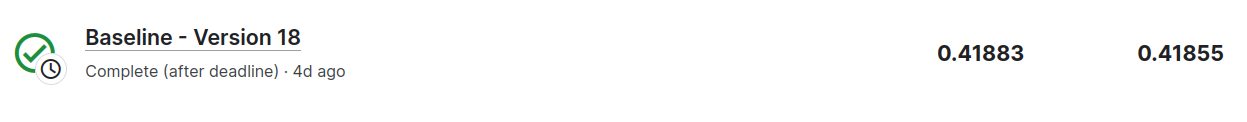

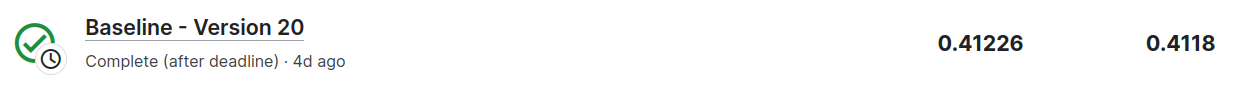

8 By looking at leadership board of for socre of 0.418 stands to 39 no posiiton which is in the **top 1.7%**



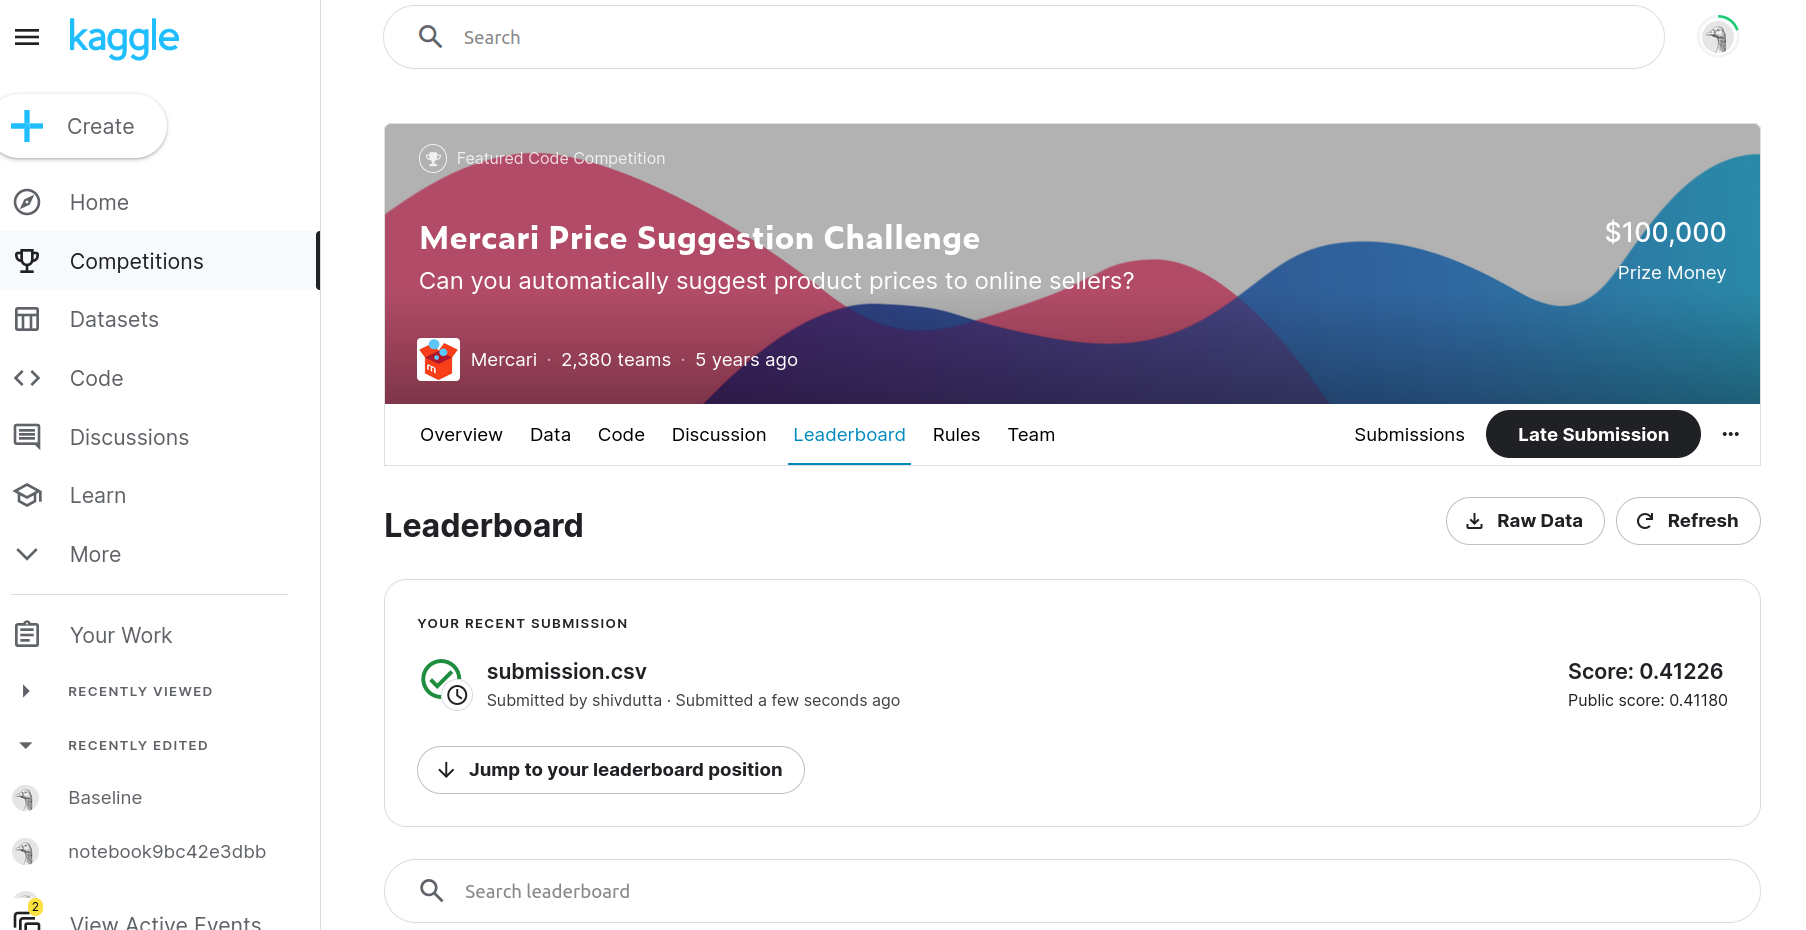

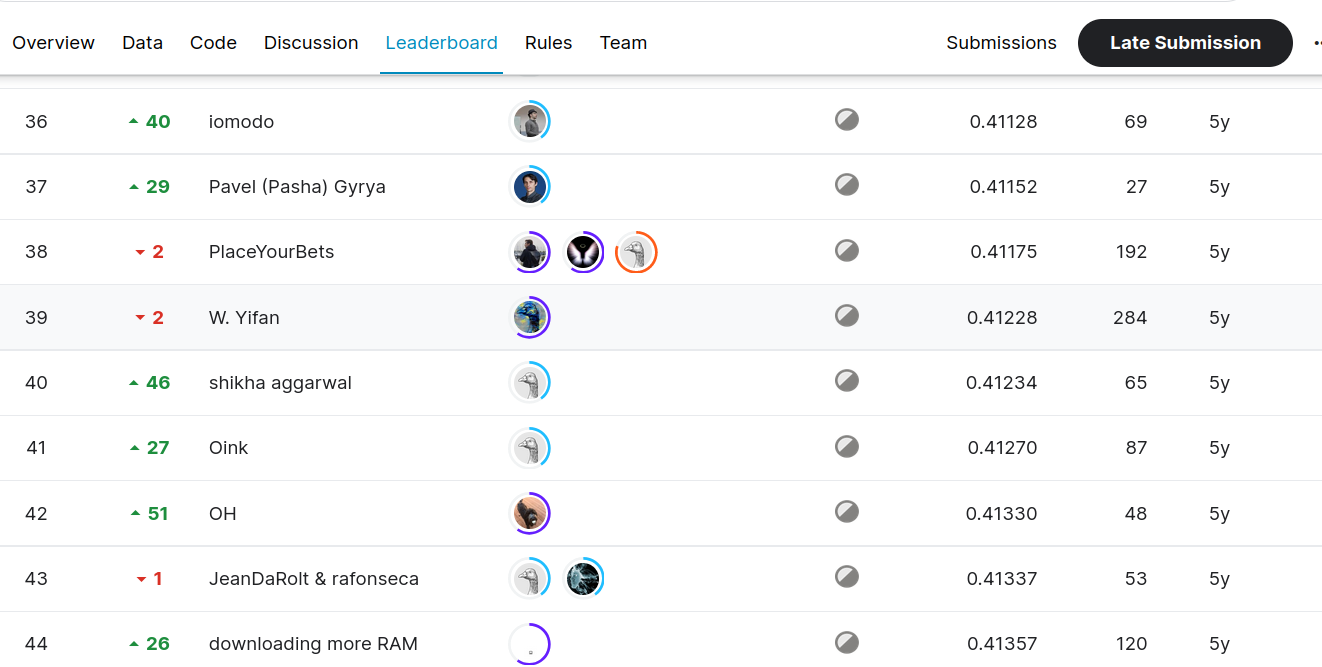